In [7]:
import os
from PIL import Image

patch_size = 128
supported_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")

def process_patch(patch):
    gray = patch.convert("L")
    reduced = gray.point(lambda x: int(x / 4) * 4)
    return reduced

def slice_image(image_path, output_subfolder, patch_size):
    image = Image.open(image_path)
    img_width, img_height = image.size
    basename = os.path.splitext(os.path.basename(image_path))[0]

    os.makedirs(output_subfolder, exist_ok=True)

    num_x = img_width // patch_size
    num_y = img_height // patch_size
    total_patches = num_x * num_y

    patch_id = 0
    for y in range(0, img_height, patch_size):
        for x in range(0, img_width, patch_size):
            box = (x, y, x + patch_size, y + patch_size)
            patch = image.crop(box)

            if patch.size[0] == patch_size and patch.size[1] == patch_size:
                processed_patch = process_patch(patch)
                patch_filename = f"{basename}_patch_{patch_id}.png"
                patch_path = os.path.join(output_subfolder, patch_filename)
                processed_patch.save(patch_path)
                patch_id += 1

def process_all_images(file_path, patch_size):
    images = [f for f in os.listdir(file_path) if f.lower().endswith(supported_extensions)]
    if not images:
        print("Brak obsługiwanych zdjęć w podanym folderze.")
        return

    for filename in os.listdir(file_path):
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(file_path, filename)
            basename = os.path.splitext(filename)[0]
            output_subfolder = os.path.join(file_path, basename)
            slice_image(image_path, output_subfolder, patch_size)

file_path = input("Podaj ścieżkę do folderu ze zdjęciami: ")
process_all_images(file_path, patch_size)

Podano ścieżkę do folderu ze zdjęciami tekstur, utworzono foldery z zdjęciami o rozdzielczości 128x128 w skali szarości.

In [8]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage.feature import graycomatrix, graycoprops

distances = [1, 3, 5]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
props = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity', 'ASM']

def extract_features(image_path, distances, angles):
    image = io.imread(image_path)
    image = (image * 255).astype(np.uint8)

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    feature_vector = []
    for prop in props:
        values = graycoprops(glcm, prop)
        feature_vector.extend(values.flatten())
    return feature_vector

def process_texture_dataset(dataset_folder, max_samples_per_class):
    rows = []
    for category in os.listdir(dataset_folder):
        category_path = os.path.join(dataset_folder, category)
        if not os.path.isdir(category_path):
            continue

        all_files = [f for f in os.listdir(category_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff"))]
        selected_files = random.sample(all_files, min(len(all_files), max_samples_per_class))

        for filename in selected_files:
            filepath = os.path.join(category_path, filename)
            features = extract_features(filepath, distances, angles)
            features.append(category)
            rows.append(features)

    return rows

def create_headers():
    headers = []
    for prop in props:
        for d in distances:
            for a_deg in [0, 45, 90, 135]:
                headers.append(f"{prop}_d{d}_a{a_deg}")
    headers.append("category")
    return headers

if __name__ == "__main__":
    dataset_folder = input("Podaj ścieżkę do folderów z przygotowanymi teksturami: ").strip()
    max_samples_per_class = int(input("Podaj liczbę próbek do przetworzenia: "))
    data = process_texture_dataset(dataset_folder, max_samples_per_class)
    headers = create_headers()
    df = pd.DataFrame(data, columns=headers)
    df.to_csv("vectors_" + str(max_samples_per_class) + ".csv", index=False)
    print("Zapisano wektory cech do pliku vectors_" + str(max_samples_per_class) + ".csv") 

Zapisano wektory cech do pliku vectors_100.csv


Podano ścieżkę do folderu nadrzędnego zawierającego foldery z przygotowanymi próbkami tekstur, utworzono plik .csv zawierający parametry dissimilarity, correlation, contrast, energy, homogeneity, ASM punktów oddalonych o 1, 3 i 5 pikseli w kierunku 0°, 45°, 90°, 135°.

Dokładność klasyfikatora: 0.7045454545454546

[[1.         0.         0.         0.        ]
 [0.         0.89655172 0.10344828 0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]]


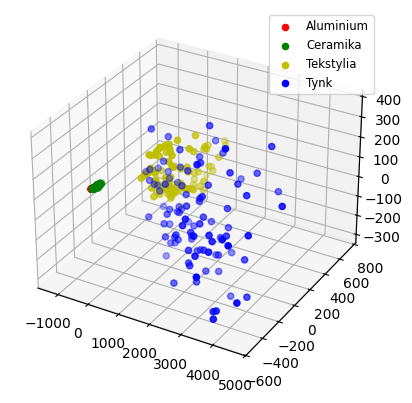

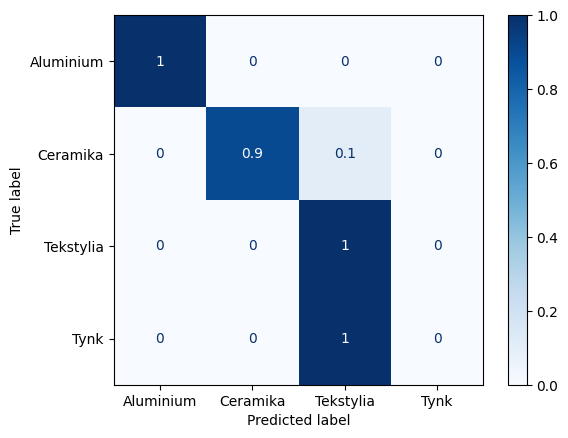

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

dataset = input("Podaj ścieżkę do pliku csv z kategoriami tekstur: ").strip()
features = pd.read_csv(dataset, sep=',')

data = np.array(features)
X = (data[:,:-1]).astype('float64')
Y = data[:,-1] # etykiety klas

x_transform = PCA(n_components=3)

Xt = x_transform.fit_transform(X)

red = Y == 'Aluminium'
green = Y == 'Ceramika'
yellow = Y == 'Tekstylia'
blue = Y == 'Tynk'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xt[red, 0], Xt[red, 1], Xt[red, 2], c="r", label="Aluminium")
ax.scatter(Xt[green, 0], Xt[green, 1], Xt[green, 2], c="g", label="Ceramika")
ax.scatter(Xt[yellow, 0], Xt[yellow, 1], Xt[yellow, 2], c="y", label="Tekstylia")
ax.scatter(Xt[blue, 0], Xt[blue, 1], Xt[blue, 2], c="b", label="Tynk")
ax.legend(loc='upper right', fontsize='small')

classifier = svm.SVC(gamma='auto') # klasyfikator SVM

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) 

classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikatora: " + str(acc) + "\n")

cm = confusion_matrix(y_test, y_pred, normalize='true')

print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Aluminium','Ceramika','Tekstylia','Tynk'])
disp.plot(cmap='Blues')
plt.show()

Podano ścieżkę do pliku .csv zawierającego próbki tekstur, po przeliczeniu uzyskano dokładność klasyfikatra na poziomie 70%. Na pierwszym wykresie widać że punkty aluminium i ceramiki znajdują się blisko siebie, a punkty tynku i tekstyliów nie przecinają się mimo że zajmują większą przestrzeń. Drugi wykres przedstawia wyniki klasyfikacji w macierzy pomyłek, w trakcie ponownych uruchomień programu, zmieniały się wskazania dla tekstyliów i tynku, ciągle wskazując podobieństwo na poziomie 1 jednocześnie dla obu z nich.